# GradCAM XAI Method Explanation

Here are the resources we used to implement the GradCAM method:
- https://keras.io/examples/vision/grad_cam/
- Google Gemini 3  

We started by following the tutorial in the Keras documentation which gave us the implementation of the `make_gradcam_heatmap` function. However, we encountered an error that we couldn't resolve, even after consulting forums, which seemed to stem from the fact that we were using nested models for fine-tuning. 

To resolve this issue, we used Google Gemini 3, which helped us code the `create_grad_cam_model` function in the `model_creation/finetune_service.py` file, allowing us to move forward.

Start by importing the needed libraries:

In [1]:
from PIL import Image
import numpy as np
from pathlib import Path
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl

c:\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Load a test image from the image dataset:

We select an image from the public image samples folder. The image is resized to 224x224 pixels (the expected input size for MobileNetV2) and converted to RGB format to ensure consistency with the model's training data format.

In [ ]:
true_label = "absent"
img_test_path = next((Path(os.getcwd()).parent.parent / "frontend" / "public" / "image" / true_label).iterdir())
img_array = np.array(Image.open(img_test_path).convert('RGB').resize((224, 224)))
img_array.shape

(224, 224, 3)

Reshape the image to add a batch dimension:

Neural networks expect batched inputs with shape (batch_size, height, width, channels). We use `np.expand_dims` to add a batch dimension at axis 0, transforming the image from shape (224, 224, 3) to (1, 224, 224, 3).

In [5]:
img_batch = np.expand_dims(img_array, axis=0)
img_array.shape, img_batch.shape

((224, 224, 3), (1, 224, 224, 3))

Load the fine-tuned classification model:

We load the MobileNetV2 model that was previously fine-tuned for our image classification task. This model will be used to make predictions on the test image.

In [ ]:
model_path = Path(os.getcwd()).parent.parent / "backend" / "models" / "image" / "mobilenet-v2" / "model.keras"
model = tf.keras.models.load_model(model_path)

Load the GradCAM model for gradient computation:

The GradCAM model is a specialized version of the classification model that outputs both the last convolutional layer activations and the predictions. This dual output is necessary to compute gradients with respect to the convolutional layer, which forms the basis of the GradCAM visualization.

In [7]:
grad_model_path = model_path.parent / "grad_model.keras"
grad_model = tf.keras.models.load_model(grad_model_path)

Apply model-specific preprocessing to the input image:

Each pre-trained model expects inputs in a specific format. For MobileNetV2, the preprocessing function scales pixel values to a range appropriate for the model. We work on a copy to preserve the original image array for later visualization.

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
img_preprocess = preprocess_input(img_batch.copy())

Define the GradCAM heatmap generation function:

This function implements the core GradCAM algorithm:
1. Compute gradients of the predicted class with respect to the last convolutional layer's activations
2. Pool the gradients globally to get importance weights for each feature map
3. Weight the feature maps by their importance and sum them to create the heatmap
4. Apply ReLU to keep only positive contributions (regions that support the prediction)
5. Normalize the heatmap to [0, 1] range for visualization

The resulting heatmap highlights the image regions that most influenced the model's prediction.

In [9]:
def make_gradcam_heatmap(img_array, grad_model, pred_index=None):
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Generate the GradCAM heatmap for the test image:

We pass the preprocessed image through the GradCAM function. Setting `pred_index=None` means the heatmap will be generated for the class with the highest predicted probability (the model's top prediction).

In [10]:
heatmap = make_gradcam_heatmap(img_preprocess, grad_model, pred_index=None)

Extract the model's prediction for the test image:

The model outputs probabilities for each class. We apply a threshold of 0.5 to convert probabilities to binary labels, then interpret the prediction at index 4 to determine if the target condition is "present" or "absent" in the image.

In [17]:
probs = model.predict(img_batch, verbose=0)[0]
labels = [1 if prob > 0.5 else 0 for prob in probs]
predicted_label = "present" if labels[4] == 1 else "absent"

Visualize the original image and GradCAM heatmap side by side:

We create a two-panel figure:
- Left panel: The original input image with its true label
- Right panel: The GradCAM heatmap showing which regions the model focused on, with the predicted label

This comparison helps evaluate whether the model is making predictions based on relevant image regions.

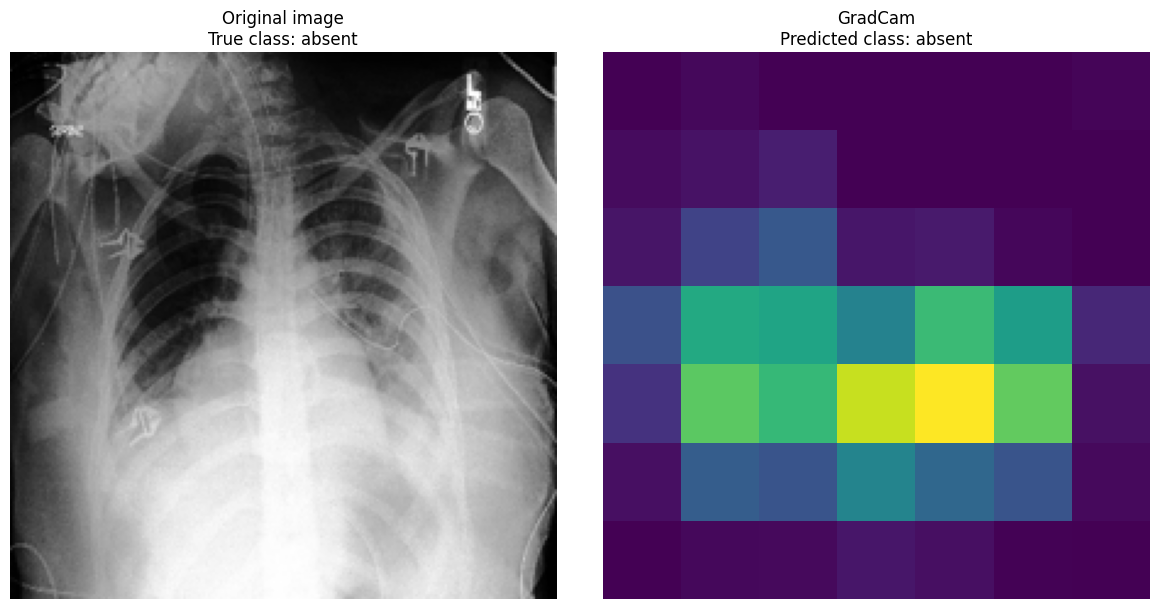

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(img_array / 255.0)
ax1.set_title(f"Original image\nTrue class: {true_label}")
ax1.axis("off")

ax2.imshow(heatmap)
ax2.set_title(f"GradCam\nPredicted class: {predicted_label}")
ax2.axis("off")

plt.tight_layout()
plt.show()

Create a superimposed visualization of the GradCAM heatmap on the original image:

This function combines the GradCAM heatmap with the original image to show exactly which parts of the image influenced the model's decision:
1. The heatmap is rescaled to 0-255 range
2. A "jet" colormap is applied (blue = low activation, red = high activation)
3. The colored heatmap is overlaid on the original image with transparency (alpha=0.4)

This superimposed view is more interpretable than showing the heatmap alone, as it preserves the original image context while highlighting important regions.

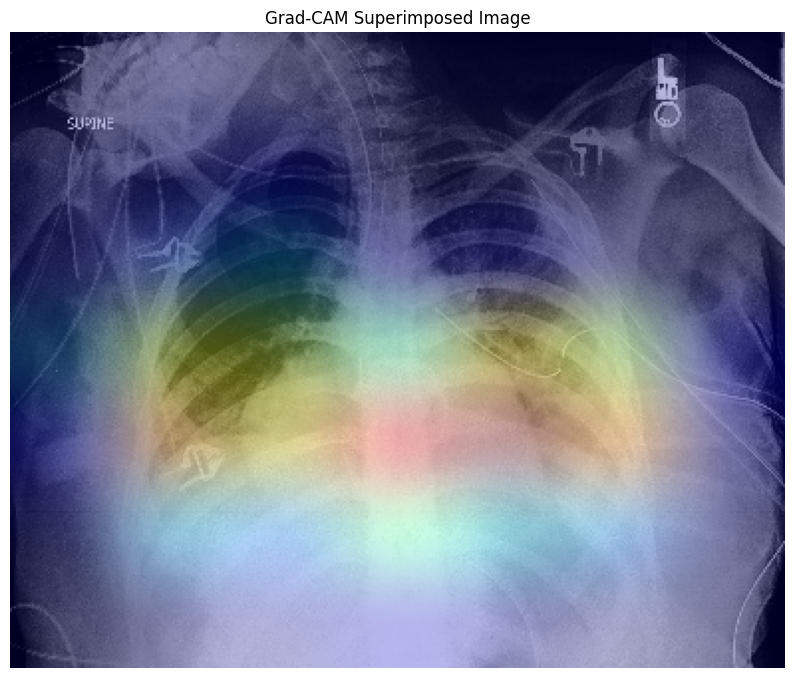

In [ ]:
def display_gradcam(img_path, heatmap, cam_path="cam_result.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM Superimposed Image")
    plt.show()


display_gradcam(str(img_test_path), heatmap)